In [13]:
import scipy.io
import keras
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage import color
import ardent

train_mat = scipy.io.loadmat('/Users/yutakobayashi/Desktop/FA2020/NDD/train_32x32.mat')
test_mat = scipy.io.loadmat('/Users/yutakobayashi/Desktop/FA2020/NDD/test_32x32.mat')
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [17]:
train_x = train_mat.get('X')
test_x = test_mat.get('X')
data_x_svhn = np.concatenate([train_x, test_x], axis=3)
train_y = train_mat.get('y')
test_y = test_mat.get('y')
data_y_svhn = np.concatenate([train_y, test_y]).reshape(-1)
data_x_svhn = data_x_svhn.transpose((3,0,1,2))
#data_x_svhn = data_x_svhn.reshape((data_x_svhn.shape[0], data_x_svhn.shape[1]*data_x_svhn.shape[2]*data_x_svhn.shape[3]))

In [7]:
data_x_mnist = np.concatenate([X_train, X_test])
#data_x_mnist = data_x_mnist.reshape((data_x_mnist.shape[0], data_x_mnist.shape[1] * data_x_mnist.shape[2]))
data_y_mnist = np.concatenate([y_train, y_test]).reshape(-1)

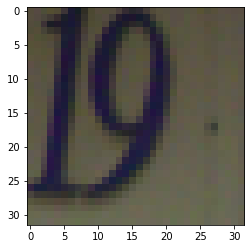

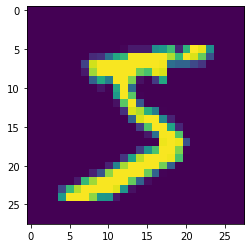

In [16]:
plt.imshow(data_x_svhn[1])
plt.figure()
plt.imshow(data_x_mnist[0])

In [ ]:


lddmm_register_kwargs = dict(
            template=template,
            target=target,
            num_iterations=150,
            num_affine_only_iterations=0,
            affine_stepsize=0,
            deformative_stepsize=0.5,
        )

output = lddmm_register(lddmm_register_kwargs)

In [4]:
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter

from joblib import Parallel, delayed
import time
from itertools import product
import pandas as pd

In [14]:
def cross_val_data(data_x_mnist, data_y_mnist, data_x_svhn, data_y_svhn, total_cls=10):
    x = data_x_mnist.copy()
    y = data_y_mnist.copy()
    x2 = data_x_svhn.copy()
    y2 = data_y_svhn.copy()
    idx = [np.where(y == u)[0] for u in np.unique(y)]
    idx2 = [np.where(y2 == u)[0] for u in np.unique(y2)]

    for i in range(total_cls):
        indx = idx[i]#np.roll(idx[i],(cv-1)*100)
        indx2 = idx2[i]
        random.shuffle(indx)
        random.shuffle(indx2)

        if i==0:
            train_x1 = x[indx[0:500],:]
            train_x2 = x2[indx2[0:500],:]
            train_y1 = y[indx[0:500]]
            train_y2 = y2[indx2[0:500]]

            test_x = x[indx[500:600],:]
            test_y = y[indx[500:600]]
        else:
            train_x1 = np.concatenate((train_x1, x[indx[0:500],:]), axis=0)
            train_x2 = np.concatenate((train_x2, x2[indx2[0:500],:]), axis=0)
            train_y1 = np.concatenate((train_y1, y[indx[0:500]]), axis=0)
            train_y2 = np.concatenate((train_y2, y2[indx2[0:500]]), axis=0)

            test_x = np.concatenate((test_x, x[indx[500:600],:]), axis=0)
            test_y = np.concatenate((test_y, y[indx[500:600]]), axis=0)


    return train_x1, train_y1, train_x2, train_y2, test_x, test_y

In [22]:
def LF_experiment(train_x1, train_y1, train_x2, train_y2, test_x, test_y, ntrees, shift, slot, num_points_per_task, acorn=None):

    df = pd.DataFrame()
  
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : 30}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                         default_transformer_kwargs = default_transformer_kwargs,
                                         default_voter_class = default_voter_class,
                                         default_voter_kwargs = default_voter_kwargs,
                                         default_decider_class = default_decider_class)

    errors = np.zeros(2)
    
    if acorn is not None:
        np.random.seed(acorn)

    progressive_learner.add_task(
        X = train_x1,
        y = train_y1,
        decider_kwargs = {"classes" : np.unique(train_y1)},
        voter_kwargs = {"classes" : np.unique(train_y1)}
    )

    progressive_learner.add_transformer(
        X = train_x2,
        y = train_y2,
        decider_kwargs = {"classes" : np.unique(train_y2)},
        voter_kwargs = {"classes" : np.unique(train_y2)},
        backward_task_ids = [0]
    )

    llf_task1=progressive_learner.predict(test_x, task_id=0)
    llf_single_task=progressive_learner.predict(test_x, task_id=0, transformer_ids=[0])
    
    errors[1] = errors[1]+(1 - np.mean(llf_task1 == test_y))
    errors[0] = errors[0]+(1 - np.mean(llf_single_task == test_y))

    print("Errors: {}".format(errors))

In [23]:
def run_parallel_exp(data_x, data_y, data_x2, data_y2, n_trees, slot=0, shift=1):
    train_x1, train_y1, train_x2, train_y2, test_x, test_y = cross_val_data(data_x, data_y, data_x2, data_y2)
    LF_experiment(train_x1, train_y1, train_x2, train_y2, test_x, test_y, n_trees, shift, slot, num_points_per_task, acorn=12345)
    
    #return df

In [24]:
num_points_per_task = 500
shifts = 2
num_slots = int(5000 // num_points_per_task)
slot_fold = range(int(5000 // num_points_per_task))

n_trees=[20] # Number of trees in UF

shift_fold = range(1,shifts,1) # Number of shifts
iterable = product(n_trees,shift_fold,slot_fold)

#df_list = run_parallel_exp(data_x_svhn, data_y_svhn, 20, num_points_per_task, slot=0, shift=0)

df_list = Parallel(n_jobs=-2,verbose=1)(
    delayed(run_parallel_exp)(
            data_x_mnist, data_y_mnist, data_x_svhn, data_y_svhn, ntree, slot=slot, shift=shift
            ) for ntree,shift,slot in iterable
            )

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   8 out of  10 | elapsed:   20.6s remaining:    5.1s


ValueError: Number of features of the model must match the input. Model n_features is 3072 and input n_features is 784 

In [11]:
print(df_list)

from tutorials.functions.label_shuffle_functions import calc_bte
from tutorials.functions.label_shuffle_functions import plot_bte

btes = calc_bte(df_list, num_slots, shifts)
plot_bte(btes)

[None, None, None, None, None, None, None, None, None, None]


TypeError: 'NoneType' object is not subscriptable